# **METODO 4**
# **Contrafactuales con aprendizaje por refuerzo (CFRL)**

Este método, descrito en el artículo [Explicaciones contrafactuales escalables y agnósticas del modelo mediante aprendizaje por refuerzo](https://arxiv.org/abs/2106.02597), puede generar instancias contrafactuales para cualquier modelo de caja negra, es decir, modelos cuyos detalles internos son desconocidos o difíciles de interpretar. 

Lo más destacado de este enfoque es que transforma el proceso de optimización habitual en un proceso de aprendizaje, lo que permite generar lotes de instancias contrafactuales en un solo paso hacia adelante, incluso para conjuntos de datos de alta dimensión. 

Un aspecto clave es que este proceso de capacitación es independiente del modelo en cuestión y se basa únicamente en la retroalimentación de predicción obtenida al consultar el modelo de caja negra. Esto significa que no importa qué tipo de modelo se esté utilizando, este método puede aplicarse de manera efectiva. 

Además, el método se distingue por su capacidad para acomodar objetivos y características específicas. Esta flexibilidad lo hace altamente adaptable a una variedad de escenarios y requisitos de aplicación, lo que lo convierte en una herramienta poderosa para comprender y explicar el comportamiento de los modelos de caja negra en diversas aplicaciones de aprendizaje automático..



En este caso de uso, ilustramos la integración con el backend de TensorFlow. Esto implica que todos los modelos involucrados, como el codificador automático, el actor y el crítico, están implementados como modelos de TensorFlow. Sin embargo, es importante destacar que nuestra implementación también es compatible con el backend de PyTorch. Esto significa que los usuarios tienen la flexibilidad de utilizar el framework que mejor se adapte a sus necesidades y preferencias, ampliando así la accesibilidad y versatilidad de nuestra solución.



**CFRL** utiliza un gradiente de política determinista profundo (DDPG), que entrelaza un aproximador de función estado-acción llamado crítico con un aproximador de aprendizaje llamado actor para predecir la acción óptima. Este método se basa en la suposición de que el crítico es diferenciable con respecto al argumento de la acción, lo que permite optimizar eficientemente los parámetros del actor a través de métodos basados en gradientes.

El algoritmo Deep Deterministic Policy Gradient(DDPG) requiere dos redes separadas, un actor $\mu$ y un crítico Q. Dada la representación codificada de la instancia de entrada $z = enc(X)$, la predicción del modelo $y_M$, la predicción objetivo $y_T$ y el vector condicionante c, el actor genera la representación latente del contrafactual $z_{CF} = \mu(z, y_M, y_T, c)$. Luego, el decodificador proyecta la incrustación $z_{CF}$ de nuevo al espacio de entrada original, seguido de un posprocesamiento opcional.

Pasamos a realizar una descripción de cómo se lleva a cabo el paso de entrenamiento: 
1. **Optimización simultánea de actores y críticos**: Durante el paso de entrenamiento, tanto el actor como el crítico se actualizan simultáneamente para mejorar el desempeño del modelo en la tarea en cuestión.

2. **Retroceso del crítico en la recompensa $R$**: El crítico ajusta sus parámetros mediante retropropagación utilizando la recompensa $R$ determinada por la predicción del modelo. Esto significa que el crítico aprende a evaluar de manera más precisa las acciones tomadas por el actor en función de la señal de recompensa.

3. **Maximización de la producción del crítico por parte del actor**: El actor ajusta sus parámetros para maximizar la salida del crítico para la instancia dada a través de $L_{max}$. Esto implica que el actor busca acciones que el crítico considere altamente valiosas en términos de la recompensa esperada.

4. **Minimización de dos objetivos adicionales del actor**:

    4.1. **Pérdida de escasez $L_{sparsity}$**: Esta pérdida opera en el contrafactual decodificado $x_{CF}$ y busca fomentar la generación de contrafactuales escasos en la distribución. Esto se logra combinando una pérdida $L_1$ sobre las características numéricas estandarizadas y una pérdida $L_0$ sobre las características categóricas.

    4.2. **Pérdida de consistencia $L_{consistency}$**: Esta pérdida pretende asegurar que el contrafactual $x_{CF}$ decodificado regrese a la misma representación latente desde donde fue decodificado. Esto ayuda a producir instancias contrafactuales coherentes en la distribución.

5. **Formalización de la pérdida del actor**: La pérdida total del actor se expresa como una combinación ponderada de las pérdidas de maximización, escasez y consistencia. Formalmente, se escribe como:

$$
L_{actor} = L_{max} + \lambda_1 L_{sparsity} + \lambda_2 L_{consistency}
$$

Donde $\lambda_1$ y $\lambda_2$ son coeficientes de ponderación que controlan la influencia relativa de cada término en la pérdida total del actor.

## Ejemplos de aplicación de la librería Alibi Explain
1. **Contrafactuales con aprendizaje por refuerzo en el censo de adultos**
2. **Contrafactuales con aprendizaje por refuerzo en MNIST**

Para habilitar la compatibilidad con CounterfactualRLTabular con backend de tensorflow, es posible que deba ejecutar:

        pip install alibi[tensorflow]

In [5]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from alibi.explainers import CounterfactualRLTabular, CounterfactualRL
from alibi.datasets import fetch_adult
from alibi.models.tensorflow import HeAE, AE
from alibi.models.tensorflow import Actor, Critic
from alibi.models.tensorflow import ADULTEncoder, ADULTDecoder
from alibi.models.tensorflow import MNISTEncoder, MNISTDecoder, MNISTClassifier
from alibi.explainers.cfrl_base import Callback
from alibi.explainers.backends.cfrl_tabular import get_he_preprocessor, get_statistics, \
    get_conditional_vector, apply_category_mapping

A continuación, iremos explicando, paso a paso, todo el planteamiento y resolución de los dos diferentes problemas, añadiendo código en algunos casos para comprender mejor que está ocurriendo en cada caso.

## **1. Contrafactuales con aprendizaje por refuerzo en el censo de adultos**

### Carga del conjunto de datos del censo de adultos

Proceddemos a la explicación de las variables del conjunto de datos a estudiar:

-***class*** : Clase o categoría a la que pertenece el individuo, como "<=50K" o ">50K" para indicar si gana menos o más de 50.000 dólares al año.

-***Age*** : La edad del individuo.

-***Workclass*** : El tipo de empleo del individuo, como "Private", "Self-emp-not-inc", etc.

-***Education*** : El nivel de educación del individuo, como "Bachelors", "HS-grad", etc.

-***Marital Status*** : El estado civil del individuo, como "Married-civ-spouse", "Divorced", etc.

-***Occupation*** : La ocupación del individuo, como "Tech-support", "Craft-repair", etc.

-***Relationship*** : La relación del individuo en la familia, como "Wife", "Own-child", etc.

-***Race*** : La raza del individuo, como "White", "Black", etc.

-***Sex*** : El sexo del individuo, "Male" o "Female".

-***Capital Gain*** : Las ganancias de capital del individuo.

-***Capital Loss*** : Las pérdidas de capital del individuo.

-***Hours per Week*** : El número de horas trabajadas por semana.

-***Country*** : El país de origen del individuo.

-***fnlwgt*** : aproximación a los antecedentes demográficos de las personas y se utiliza como un factor de ponderación en el conjunto de datos.

Procedemos a cargar el conjunto de datos, separar las columnas en variables categóricas y numéricas, y finalmente, dividir los datos en dos conjuntos: de entrenamiento y de prueba.


In [2]:
# Fetch adult dataset
adult = fetch_adult()

# Separate columns in numerical and categorical.
categorical_names = [adult.feature_names[i] for i in adult.category_map.keys()]
categorical_ids = list(adult.category_map.keys())

numerical_names = [name for i, name in enumerate(adult.feature_names) if i not in adult.category_map.keys()]
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map.keys()]

# Split data into train and test
X, Y = adult.data, adult.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

### Clasificador de caja negra de tren

Se definen transformadores para estandarizar variables numéricas y codificar variables categóricas mediante one-hot encoding. Luego, se utiliza un transformador de columnas para aplicar estas transformaciones a las columnas correspondientes del conjunto de datos.

In [3]:
# Define numerical standard scaler.
num_transf = StandardScaler()

# Define categorical one-hot encoder.
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown="ignore"
)

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transf, categorical_ids),
        ("num", num_transf, numerical_ids),
    ],
    sparse_threshold=0
)

Entrenamos el preprocesador con los datos de entrenamiento y luego aplicamos el preprocesamiento a los conjuntos de datos de entrenamiento y prueba, transformándolos según las transformaciones definidas anteriormente.

In [4]:
# Fit preprocessor.
preprocessor.fit(X_train)

# Preprocess train and test dataset.
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

Selecciona un clasificador `RandomForestClassifier` con ciertos hiperparámetros y lo ajustamos utilizando los datos de entrenamiento preprocesados.

In [5]:
# Select one of the below classifiers.
# clf = XGBClassifier(min_child_weight=0.5, max_depth=3, gamma=0.2)
# clf = LogisticRegression(C=10)
# clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
clf = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

# Fit the classifier.
clf.fit(X_train_ohe, Y_train)

RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

### Definir el predictor (caja negra)

Ahora que hemos entrenado al clasificador, podemos definir el modelo de caja negra. A tener en cuenta que la salida de la caja negra es una distribución que puede ser una distribución de etiqueta suave (probabilidades/logits para cada clase) o una distribución de etiqueta dura (codificación one-hot). Internamente, **CFRL** toma el `argmax`. Además, la salida **NO TIENE QUE SER DIFERENCIABLE**.

Definimos una función de predicción llamada **predictor**, que toma un conjunto de datos como entrada (x), lo preprocesa utilizando el preprocesador definido anteriormente y luego utiliza el clasificador entrenado (**clf**) para predecir las probabilidades de pertenencia a cada clase para cada instancia en el conjunto de datos de entrada

In [6]:
# Define prediction function.
predictor = lambda x: clf.predict_proba(preprocessor.transform(x))

Calculamos su accuracy:

In [7]:
# Compute accuracy.
acc = accuracy_score(y_true=Y_test, y_pred=predictor(X_test).argmax(axis=1))
print("Accuracy: %.3f" % acc)

Accuracy: 0.864


Observamos un accuracy del 86.4%.

### Definir y entrenar el codificador automático

En lugar de modelar directamente el vector de perturbación en el espacio de entrada potencialmente de alta dimensión, primero entrenamos un codificador automático. Los pesos del codificador se congelan y el actor aplica las perturbaciones contrafácticas en el espacio latente del codificador. El decodificador previamente entrenado mapea la incorporación contrafactual al espacio de características de entrada.

El codificador automático sigue un diseño estándar. El modelo se compone de dos submódulos, el codificador(encoder) y el decodificador(decoder). El pase directo consiste en pasar la entrada al codificador, obtener la incrustación de la entrada y pasar la incrustación a través del decodificador.

In [8]:
class HeAE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

La variante heterogénea utilizada en este ejemplo utiliza una verificación de tipo adicional para garantizar que la salida del decodificador sea una lista de tensores.

Los conjuntos de datos heterogéneos requieren un tratamiento especial. En este trabajo modelamos las características numéricas mediante distribuciones normales con desviación estándar constante y las características categóricas mediante distribuciones categóricas. Debido a la elección del modelado de características, algunas características numéricas pueden terminar teniendo tipos diferentes a las características numéricas originales. Por ejemplo, una característica como Agetener el tipo de intpuede convertirse en una característica floatdebido a la reconstrucción del codificador automático (p. ej., ). Este comportamiento puede ser indeseable. Por lo tanto, realizamos la conversión cuando procesamos la salida del codificador automático (componente decodificador). ***Age***=26 -> ***Age***=26.3

In [9]:
# Define attribute types, required for datatype conversion.
feature_types = {"Age": int, "Capital Gain": int, "Capital Loss": int, "Hours per week": int}

# Define data preprocessor and inverse preprocessor. The invers preprocessor include datatype conversions.
heae_preprocessor, heae_inv_preprocessor = get_he_preprocessor(X=X_train,
                                                               feature_names=adult.feature_names,
                                                               category_map=adult.category_map,
                                                               feature_types=feature_types)

# Define trainset
trainset_input = heae_preprocessor(X_train).astype(np.float32)
trainset_outputs = {
    "output_1": trainset_input[:, :len(numerical_ids)]
}

for i, cat_id in enumerate(categorical_ids):
    trainset_outputs.update({
        f"output_{i+2}": X_train[:, cat_id]
    })

trainset = tf.data.Dataset.from_tensor_slices((trainset_input, trainset_outputs))
trainset = trainset.shuffle(1024).batch(128, drop_remainder=True)

In [10]:
# Define autoencoder path and create dir if it doesn't exist.
heae_path = os.path.join("tensorflow", "ADULT_autoencoder")
if not os.path.exists(heae_path):
    os.makedirs(heae_path)

# Define constants.
EPOCHS = 50              # epochs to train the autoencoder
HIDDEN_DIM = 128         # hidden dimension of the autoencoder
LATENT_DIM = 15          # define latent dimension

# Define output dimensions.
OUTPUT_DIMS = [len(numerical_ids)]
OUTPUT_DIMS += [len(adult.category_map[cat_id]) for cat_id in categorical_ids]

# Define the heterogeneous auto-encoder.
heae = HeAE(encoder=ADULTEncoder(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM),
            decoder=ADULTDecoder(hidden_dim=HIDDEN_DIM, output_dims=OUTPUT_DIMS))

# Define loss functions.
he_loss = [keras.losses.MeanSquaredError()]
he_loss_weights = [1.]

# Add categorical losses.
for i in range(len(categorical_names)):
    he_loss.append(keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    he_loss_weights.append(1./len(categorical_names))

# Define metrics.
metrics = {}
for i, cat_name in enumerate(categorical_names):
    metrics.update({f"output_{i+2}": keras.metrics.SparseCategoricalAccuracy()})

# Compile model.
heae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=he_loss,
             loss_weights=he_loss_weights,
             metrics=metrics)

if len(os.listdir(heae_path)) == 0:
    # Fit and save autoencoder.
    heae.fit(trainset, epochs=EPOCHS)
    heae.save(heae_path, save_format="tf")
else:
    # Load the model.
    heae = keras.models.load_model(heae_path, compile=False)

### Contrafactual con aprendizaje por refuerzo

Se van a definir a continuación diferentes constantes, vamos a adentrarnos un poco más en la comprensión de estas:

-`COEFF_SPARSITY`: controla la importancia de la regularización por esparcidad durante el entrenamiento del modelo, que ayuda a que las activaciones de las neuronas sean dispersas, lo que puede mejorar la capacidad de generalización del modelo y prevenir el sobreajuste.

-`COEFF_CONSISTENCY`: controla la importancia de la consistencia en la reconstrucción durante el entrenamiento del autoencoder, capacidad del autoencoder para reconstruir fielmente los datos de entrada. Controlar esta consistencia puede ayudar a mejorar la calidad de la reconstrucción y, en última instancia, la capacidad del autoencoder para capturar las características importantes de los datos.

-`TRAIN_STEPS`: número de pasos de entrenamiento que se realizarán durante el entrenamiento del modelo. Cuantos más pasos de entrenamiento se realicen, más oportunidades tiene el modelo de ajustarse a los datos de entrenamiento. Aumentar este valor puede conducir a un mejor rendimiento del modelo, pero también puede aumentar el tiempo de entrenamiento.

-`BATCH_SIZE`: tamaño del lote utilizado durante el entrenamiento, que determina cuántas muestras se procesan simultáneamente antes de actualizar los pesos del modelo. Un tamaño de lote más grande puede acelerar el entrenamiento y mejorar la estabilidad del gradiente, pero también puede requerir más memoria y tiempo de cómputo.

In [11]:
# Define constants
COEFF_SPARSITY = 0.5               # sparisty coefficient
COEFF_CONSISTENCY = 0.5            # consisteny coefficient
TRAIN_STEPS = 10000                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100                   # batch size

#### Definir atributos y restricciones específicos del conjunto de datos.

Una propiedad deseable de un método para generar contrafactuales es permitir el condicionamiento de características. Los conjuntos de datos del mundo real suelen incluir características inmutables como ***Sex*** o ***Race***, que deben permanecer sin cambios durante todo el procedimiento de búsqueda contrafactual. De manera similar, una característica numérica como ***Age*** solo debería aumentar para que un contrafactual sea procesable.

Vamos a definir cuales son estas características inmutables y rangos para la característica ***Age***, para que no pueda decrecer.

In [12]:
# Define immutable features.
immutable_features = ['Marital Status', 'Relationship', 'Race', 'Sex']

# Define ranges. This means that the `Age` feature can not decrease.
ranges = {'Age': [0.0, 1.0]}

Creamos un explicador de contrafactuales utilizando la clase `CounterfactualRLTabular`.

In [13]:
explainer = CounterfactualRLTabular(predictor=predictor,
                                    encoder=heae.encoder,
                                    decoder=heae.decoder,
                                    latent_dim=LATENT_DIM,
                                    encoder_preprocessor=heae_preprocessor,
                                    decoder_inv_preprocessor=heae_inv_preprocessor,
                                    coeff_sparsity=COEFF_SPARSITY,
                                    coeff_consistency=COEFF_CONSISTENCY,
                                    category_map=adult.category_map,
                                    feature_names=adult.feature_names,
                                    ranges=ranges,
                                    immutable_features=immutable_features,
                                    train_steps=TRAIN_STEPS,
                                    batch_size=BATCH_SIZE,
                                    backend="tensorflow")

Lo entrenamos con el conjunto de entrenamiento.

In [14]:
# Fit the explainer.
explainer = explainer.fit(X=X_train)

100%|██████████| 10000/10000 [04:42<00:00, 35.40it/s]


### Explicador de prueba

Seleccionamos algunos ejemplos positivos del conjunto de datos de prueba basándonos en las predicciones del modelo. Luego, seleccionamos los primeros 1000 ejemplos positivos y establecemos sus etiquetas objetivo como 0. Además, definimos las restricciones para la generación de contrafactuales, limitando la edad entre 0 y 20 años y restringiendo las opciones de clase de trabajo a *"State-gov"*, *"?"* y *"Local-gov"*.

In [15]:
# Select some positive examples.
X_positive = X_test[np.argmax(predictor(X_test), axis=1) == 1]

X = X_positive[:1000]
Y_t = np.array([0])
C = [{"Age": [0, 20], "Workclass": ["State-gov", "?", "Local-gov"]}]

Generamos instancias contrafactuales utilizando el explicador explainer para los ejemplos X con las etiquetas objetivo Y_t y las restricciones C.

In [16]:
# Generate counterfactual instances.
explanation = explainer.explain(X, Y_t, C)

100%|██████████| 10/10 [00:00<00:00, 66.52it/s]


Concatenamos las etiquetas a las instancias originales y a las instancias contrafactuales generadas. Definimos nuevos nombres de características y un nuevo mapa de categorías que incluyen la etiqueta. Posteriormente, reemplazamos las codificaciones de las etiquetas con cadenas de texto para facilitar la interpretación de los resultados. Finalmente, creamos DataFrames con las instancias originales y contrafactuales.

In [17]:
# Concat labels to the original instances.
orig = np.concatenate(
    [explanation.data['orig']['X'], explanation.data['orig']['class']],
    axis=1
)

# Concat labels to the counterfactual instances.
cf = np.concatenate(
    [explanation.data['cf']['X'], explanation.data['cf']['class']],
    axis=1
)

# Define new feature names and category map by including the label.
feature_names = adult.feature_names + ["Label"]
category_map = deepcopy(adult.category_map)
category_map.update({feature_names.index("Label"): adult.target_names})

# Replace label encodings with strings.
orig_pd = pd.DataFrame(
    apply_category_mapping(orig, category_map),
    columns=feature_names
)

cf_pd = pd.DataFrame(
    apply_category_mapping(cf, category_map),
    columns=feature_names
)

In [18]:
cf_pd.head(n=10)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Label
0,60,State-gov,High School grad,Married,Blue-Collar,Husband,White,Male,1355,0,40,United-States,<=50K
1,36,?,High School grad,Married,?,Husband,White,Male,2435,0,50,United-States,<=50K
2,39,?,High School grad,Married,?,Wife,White,Female,1317,0,38,United-States,<=50K
3,44,?,High School grad,Married,Sales,Husband,White,Male,0,16,51,United-States,<=50K
4,44,?,High School grad,Married,?,Husband,White,Male,0,0,40,United-States,<=50K
5,39,Private,Bachelors,Separated,White-Collar,Not-in-family,White,Female,2229,0,50,United-States,<=50K
6,45,?,High School grad,Married,?,Husband,White,Male,0,1823,41,Latin-America,<=50K
7,51,?,High School grad,Married,?,Husband,White,Male,0,0,50,United-States,<=50K
8,29,?,High School grad,Married,Service,Wife,White,Female,0,0,48,United-States,<=50K
9,48,?,High School grad,Married,?,Husband,White,Male,0,0,50,United-States,<=50K


### Diversidad

Generamos una instancia contrafactual para un solo ejemplo positivo y lo remodelamos para que tenga la forma adecuada para el explicador. Luego, utilizamos el explicador para generar la explicación de la instancia contrafactual.

In [19]:
# Generate counterfactual instances.
X = X_positive[0].reshape(1, -1)
explanation = explainer.explain(X=X, Y_t=Y_t, C=C, diversity=True, num_samples=100, batch_size=10)

11it [00:00, 55.10it/s]


In [20]:
# Concat label column.
orig = np.concatenate(
    [explanation.data['orig']['X'], explanation.data['orig']['class']],
    axis=1
)

cf = np.concatenate(
    [explanation.data['cf']['X'], explanation.data['cf']['class']],
    axis=1
)

# Transfrom label encodings to string.
orig_pd = pd.DataFrame(
    apply_category_mapping(orig, category_map),
    columns=feature_names,
)

cf_pd = pd.DataFrame(
    apply_category_mapping(cf, category_map),
    columns=feature_names,
)

Mostramos las instancias originales (**orig_pd**) y las instancias contrafactuales generadas (**cf_pd**). 

In [21]:
orig_pd.head(n=5)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Label
0,60,Private,High School grad,Married,Blue-Collar,Husband,White,Male,7298,0,40,United-States,>50K


In [22]:
cf_pd.head(n=5)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Label
0,60,?,High School grad,Married,?,Husband,White,Male,1312,0,40,United-States,<=50K
1,60,?,High School grad,Married,?,Husband,White,Male,1358,0,40,United-States,<=50K
2,60,?,High School grad,Married,Blue-Collar,Husband,White,Male,1087,0,40,United-States,<=50K
3,60,?,High School grad,Married,Blue-Collar,Husband,White,Male,1116,0,40,United-States,<=50K
4,60,?,High School grad,Married,Blue-Collar,Husband,White,Male,1150,0,40,United-States,<=50K


Estos conjuntos de datos representan instancias originales y sus respectivas instancias contrafactuales, donde se han realizado cambios en algunas características mientras se mantienen otras constantes. Concretamente, lo que nos llama más la atención es lo siguiente:

- **Aparecen valores imputados**. Cuando observamos en conjunto de datos contrafactual, algunos valores han sido imputados o modificados, por ejemplo, en la columna ***Workclass*** los valores originales son específicos (*"Private"* para el primer registro), mientras que en el conjunto de datos contrafactual, estos valores han sido reemplazados por un signo de interrogación (*"?"*). Esto también ocurre en algunas de las entradas de la variable ***Occupation***.

- **Observamos cambios en algunas variables**. Por ejemplo, en todos los registros del conjunto de datos contrafactual se observan cambios en la columna ***Capital Gain*** en comparación con el registro original.

- **Consistencia en algunas características**. Aunque se han realizado cambios en algunas características, otras parecen permanecer consistentes. Por ejemplo, las columnas ***Age***, ***Education***, ***Marital Status***, ***Relationship***, ***Race***, ***Sex***, ***Hours per week***, y ***Country*** parecen no haber sido modificadas entre los conjuntos de datos original y contrafactual observados.

## **2. Contrafactuales con aprendizaje por refuerzo en MNIST**

### Cargar conjunto de datos MNIST

El conjunto de datos MNIST contiene un conjunto de entrenamiento de 60.000 imágenes en escala de grises de 28x28 de 10 dígitos, junto con un conjunto de prueba de 10.000 imágenes.

Los dígitos representados varían entre el 0 y el 9, por lo que tendremos solamente representaciones de estos.

Definimos las constantes `BATCH_SIZE` y `BUFFER_SIZE` con valores 64 y 1024, respectivamente. Cargamos el conjunto de datos MNIST, expandiendo las dimensiones de las imágenes y normalizándolas. Finalmente, creamos un conjunto de entrenamiento (**trainset_classifier**) y un conjunto de prueba (**testset_classifier**), ambos mezclados y agrupados en lotes de tamaño `BATCH_SIZE`.


In [6]:
# Define constants.
BATCH_SIZE = 64
BUFFER_SIZE = 1024

# Load MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Expand dimensions and normalize.
X_train = np.expand_dims(X_train, axis=-1).astype(np.float32) / 255.
X_test = np.expand_dims(X_test, axis=-1).astype(np.float32) / 255.

# Define trainset.
trainset_classifier = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
trainset_classifier = trainset_classifier.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

# Define testset.
testset_classifier = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
testset_classifier = testset_classifier.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

### Definir y entrenar el clasificador CNN

Definimos un clasificador para datos de MNIST con 10 clases especificando la ruta para guardar el modelo y se creando el directorio si es necesario. El clasificador se compila con un optimizador `Adam` y la función de pérdida de `SparseCategoricalCrossentropy`.

In [7]:
# Number of classes.
NUM_CLASSES = 10
EPOCHS = 5

# Define classifier path and create dir if it doesn't exist.
classifier_path = os.path.join("tensorflow", "MNIST_classifier")
if not os.path.exists(classifier_path):
    os.makedirs(classifier_path)

# Construct classifier. This is the classifier used in the paper experiments.
classifier = MNISTClassifier(output_dim=NUM_CLASSES)

# Define optimizer and loss function
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Complile the model.
classifier.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


if len(os.listdir(classifier_path)) == 0:
    # Fit and save the classifier.
    classifier.fit(trainset_classifier, epochs=EPOCHS)
    classifier.save(classifier_path)
else:
    # Load the classifier if already fitted.
    classifier = keras.models.load_model(classifier_path)

### Definir el predictor (caja negra)

Ahora que hemos entrenado el clasificador CNN, podemos definir el modelo de caja negra. Tenga en cuenta que la salida de la caja negra es una distribución que puede ser una distribución de etiqueta suave (probabilidades/logits para cada clase) o una distribución de etiqueta dura (codificación one-hot). Internamente, CFRL toma el argmax. Además, la salida NO TIENE QUE SER DIFERENCIABLE .

In [8]:
# Define predictor function (black-box) used to train the CFRL
def predictor(X: np.ndarray):
    Y = classifier(X).numpy()
    return Y

### Definir y entrenar el codificador automático

En lugar de modelar directamente el vector de perturbación en el espacio de entrada potencialmente de alta dimensión, primero entrenamos un codificador automático. Los pesos del codificador se congelan y el actor aplica las perturbaciones contrafácticas en el espacio latente del codificador. El decodificador previamente entrenado mapea la incorporación contrafactual al espacio de características de entrada.

El codificador automático sigue un diseño estándar. El modelo se compone de dos submódulos, el codificador y el decodificador. El pase directo consiste en pasar la entrada al codificador, obtener la incrustación de la entrada y pasar la incrustación a través del decodificador.

In [9]:
class AE(keras.Model):
    def __init__(self, encoder: keras.Model, decoder: keras.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x: tf.Tensor, **kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

Definimos conjuntos de datos para el entrenamiento (**trainset_ae**) y prueba (**testset_ae**) del autoencoder, donde cada uno de ellos se crea a partir de los datos de entrada X_train y X_test, respectivamente. Además, se empareja cada muestra consigo misma y se realiza un mezclado y agrupamiento en lotes de tamaño `BATCH_SIZE`.

In [10]:
# Define autoencoder trainset.
trainset_ae = tf.data.Dataset.from_tensor_slices(X_train)
trainset_ae = trainset_ae.map(lambda x: (x, x))
trainset_ae = trainset_ae.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

# Define autoencode testset.
testset_ae = tf.data.Dataset.from_tensor_slices(X_test)
testset_ae = testset_ae.map(lambda x: (x, x))
testset_ae = testset_ae.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

Definimos un autoencoder especificando la ruta de guardado y creando el directorio si es necesario, junto con `LATENT_DIM` y `EPOCHS`. Luego, compilamos el modelo con un optimizador `Adam` y la función de pérdida de `BinaryCrossentropy`. Finalmente, ajustamos el autoencoder a los datos de entrenamiento, guardándolo si el directorio está vacío o cargando un modelo previamente guardado.

In [11]:
# Define autoencoder path and create dir if it doesn't exist.
ae_path = os.path.join("tensorflow", "MNIST_autoencoder")
if not os.path.exists(ae_path):
    os.makedirs(ae_path)

# Define latent dimension.
LATENT_DIM = 64
EPOCHS = 50

# Define autoencoder.
ae = AE(encoder=MNISTEncoder(latent_dim=LATENT_DIM),
        decoder=MNISTDecoder())

# Define optimizer and loss function.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy(from_logits=False)

# Compile autoencoder.
ae.compile(optimizer=optimizer, loss=loss)

if len(os.listdir(ae_path)) == 0:
    # Fit and save autoencoder.
    ae.fit(trainset_ae, epochs=EPOCHS)
    ae.save(ae_path)
else:
    # Load the model.
    ae = keras.models.load_model(ae_path)

### Prueba del codificador automático

Definimos el número de muestras para ser mostradas (`NUM_SAMPLES`) y seleccionamos aleatoriamente algunas muestras de prueba (`X_test`). Luego, pasamos estas muestras a través del autoencoder (`ae`) y almacenamos las reconstrucciones en `inputs_hat`.

In [12]:
# Define number of samples to be displayed
NUM_SAMPLES = 5

# Get some random samples from test
np.random.seed(0)
indices = np.random.choice(X_test.shape[0], NUM_SAMPLES)
inputs = [X_test[i].reshape(1, 28, 28, 1) for i in indices]
inputs = np.concatenate(inputs, axis=0)

# Pass samples through the autoencoder
inputs_hat = ae(inputs).numpy()

Visualizamos las muestras originales (`inputs`) y sus reconstrucciones (`inputs_hat`) generadas por el autoencoder. Creamos una figura con dos filas y un número de columnas igual al número de muestras (`NUM_SAMPLES`). Cada muestra original y su reconstrucción se muestran en una columna respectiva.

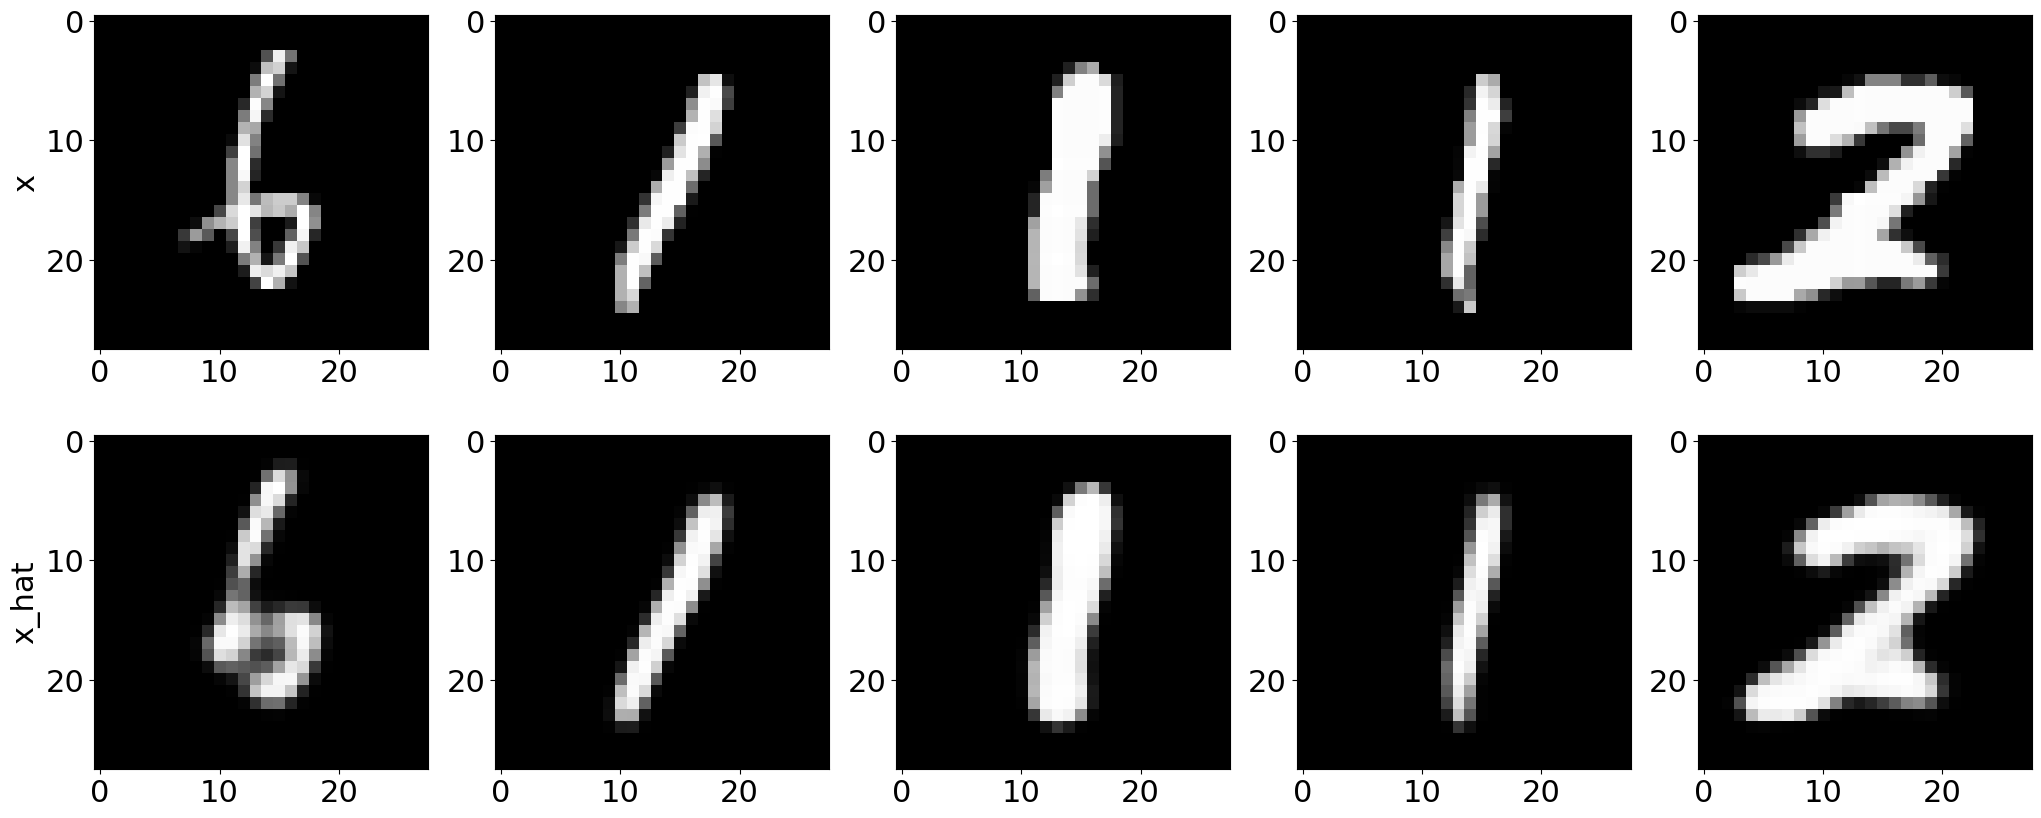

In [13]:
import matplotlib.pyplot as plt 
# Plot inputs and reconstructions.
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(2, NUM_SAMPLES, figsize=(25, 10))

for i in range(NUM_SAMPLES):
    ax[0][i].imshow(inputs[i], cmap='gray')
    ax[1][i].imshow(inputs_hat[i], cmap='gray')

text1 = ax[0][0].set_ylabel("x")
text2 = ax[1][0].set_ylabel("x_hat")

### Contrafactual con aprendizaje por refuerzo

Si queremos recordar la intuición que hay detrás de cada uno de estos coeficientes, será conveniente revisar el ejemplo de aplicación 1, donde estas fueron explicadas una a una.

In [14]:
# Define constants
COEFF_SPARSITY = 7.5               # sparisty coefficient
COEFF_CONSISTENCY = 0              # consisteny coefficient -> no consistency
TRAIN_STEPS = 50000                # number of training steps -> consider increasing the number of steps
BATCH_SIZE = 100                   # batch size

### Definir y ajustar al explicador

Definimos un explicador de contrafactuales utilizando la clase `CounterfactualRL`.

In [15]:
# Define explainer.
explainer = CounterfactualRL(predictor=predictor,
                             encoder=ae.encoder,
                             decoder=ae.decoder,
                             latent_dim=LATENT_DIM,
                             coeff_sparsity=COEFF_SPARSITY,
                             coeff_consistency=COEFF_CONSISTENCY,
                             train_steps=TRAIN_STEPS,
                             batch_size=BATCH_SIZE,
                             backend="tensorflow")

Ajustamos el explicador a los datos de entrenamiento para generar explicaciones de contrafactuales.

In [16]:
# Fit the explainer
explainer = explainer.fit(X=X_train)

100%|██████████| 50000/50000 [1:14:20<00:00, 11.21it/s]


### Explicador de prueba

Generamos explicaciones de contrafactuales para una selección de instancias de prueba (X_test[0:200]) con la etiqueta objetivo especificada (Y_t=np.array([2])). Se realiza en lotes de tamaño 100.

In [17]:
# Generate counterfactuals for some test instances.
explanation = explainer.explain(X_test[0:200], Y_t=np.array([2]), batch_size=100)

100%|██████████| 2/2 [00:00<00:00, 21.15it/s]


Visualizamos las instancias originales (**explanation.data['orig']['X']**) y sus contrafactuales correspondientes (**explanation.data['cf']['X']**). Las imágenes se muestran en filas separadas, donde la fila superior muestra las instancias originales y la fila inferior muestra las contrafactuales. Además, mostraremos la etiqueta de cada instancia en el eje x de cada subfigura.


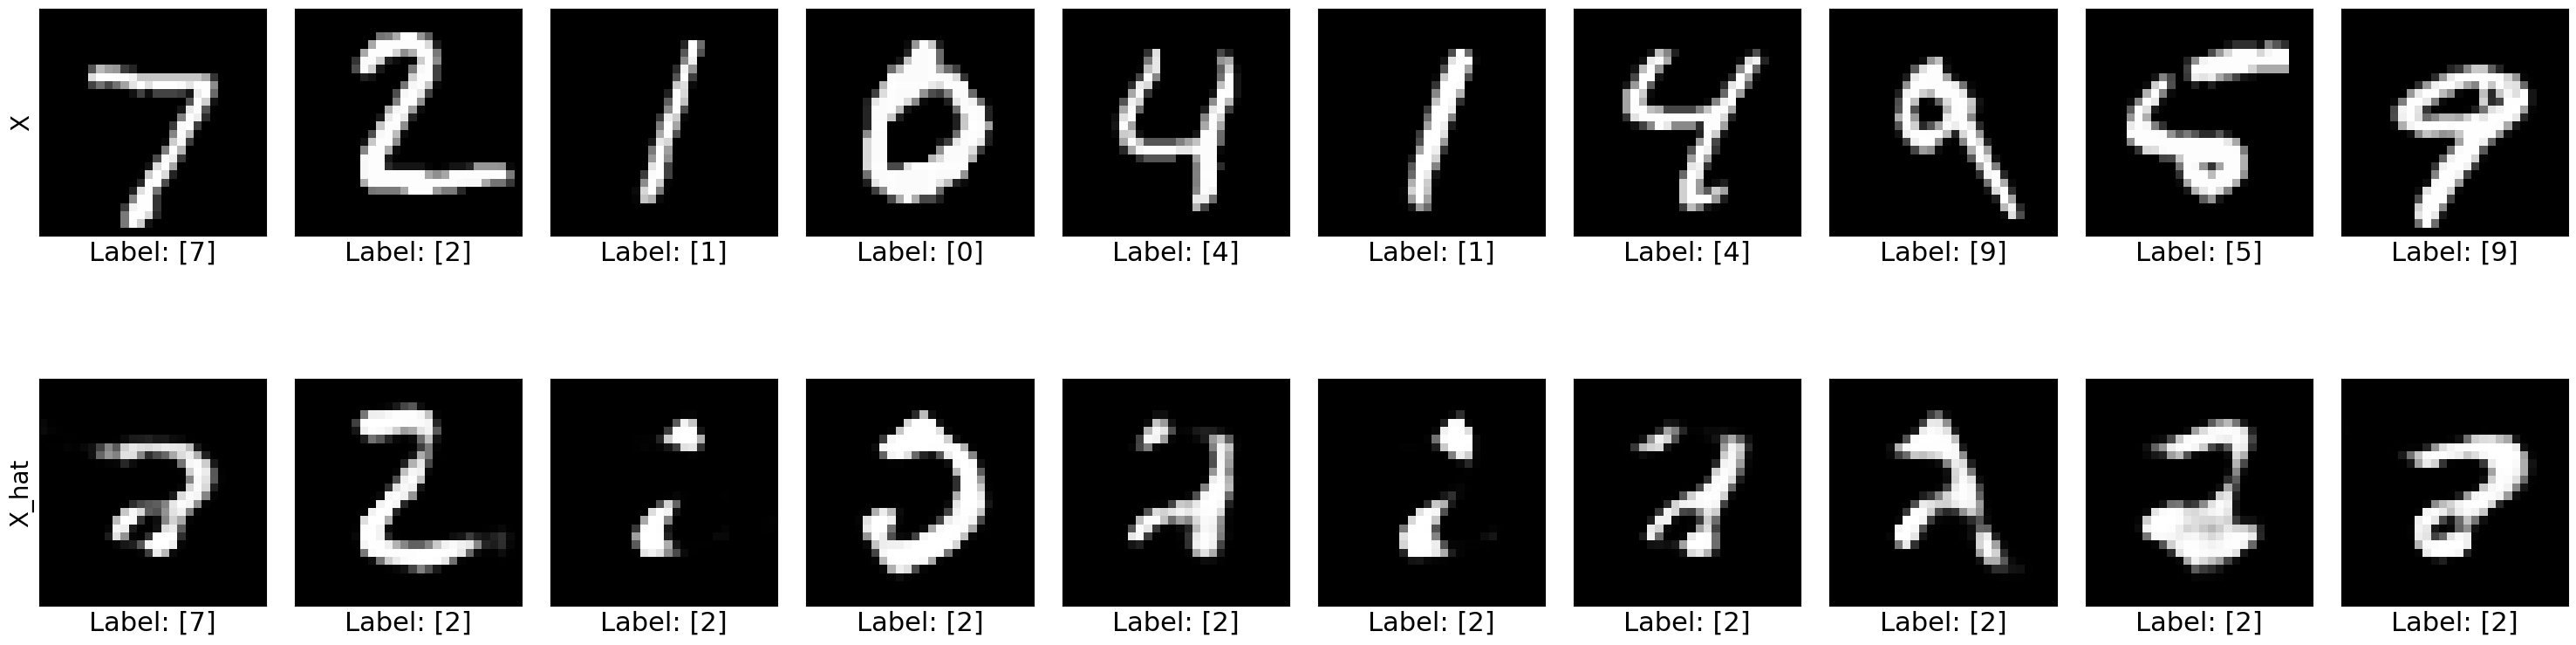

In [22]:
fig, ax = plt.subplots(2, 10, figsize=(30, 10))

for i in range(10):
    ax[0][i].imshow(explanation.data['orig']['X'][i], cmap='gray')
    ax[1][i].imshow(explanation.data['cf']['X'][i], cmap='gray')

    ax[0][i].set_xlabel("Label: " + str(explanation.data['orig']['class'][i]))
    ax[1][i].set_xlabel("Label: " + str(explanation.data['cf']['class'][i]))

    ax[0][i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[0][i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax[1][i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[1][i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

text1 = ax[0][0].set_ylabel("X", fontsize=20)
text2 = ax[1][0].set_ylabel("X_hat", fontsize=20)
plt.tight_layout()
plt.show()


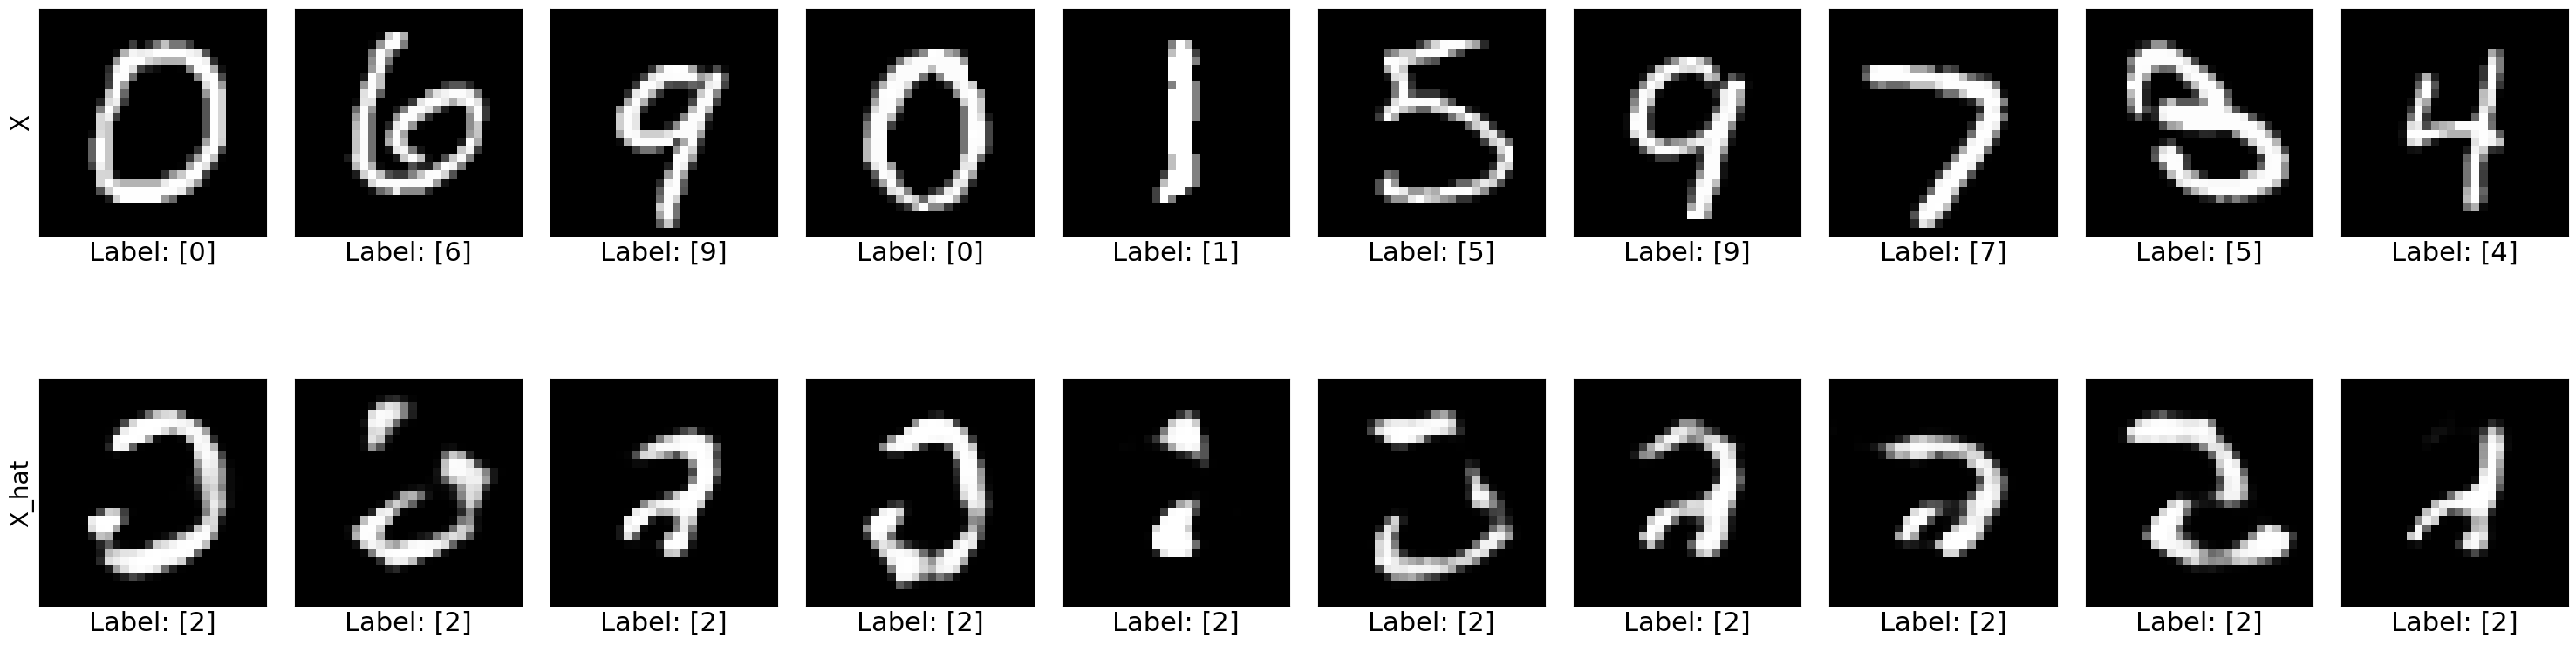

In [26]:
fig, ax = plt.subplots(2, 10, figsize=(30, 10))

for i in range(10, 20):
    col = i % 10

    ax[0][col].imshow(explanation.data['orig']['X'][i], cmap='gray')
    ax[1][col].imshow(explanation.data['cf']['X'][i], cmap='gray')

    ax[0][col].set_xlabel("Label: " + str(explanation.data['orig']['class'][i]))
    ax[1][col].set_xlabel("Label: " + str(explanation.data['cf']['class'][i]))

    ax[0][col].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[0][col].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax[1][col].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[1][col].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

text1 = ax[0][0].set_ylabel("X", fontsize=20)
text2 = ax[1][0].set_ylabel("X_hat", fontsize=20)
plt.tight_layout()
plt.show()


Estos datos que acabamos de observar, representan las instancias originales y sus respectivas instancias contrafactuales de las 20 primeras muestras de datos, donde se han realizado cambios en las características de las própias imágenes con la finalidad de asemejarse a la clase con etiqueta 2.



Para obtener más información sobre este método, visita alguno de los siguientes enlaces de la librería Alibi Explain:

https://docs.seldon.io/projects/alibi/en/latest/overview/high_level.html#counterfactuals-with-reinforcement-learning

https://docs.seldon.io/projects/alibi/en/latest/methods/CFRL.html